In [2]:
import MilneEddington 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [3]:
#Load the data
stokes = fits.open('/home/milic/data/Hinode_network/hinode_network_c.fits')[0].data

In [4]:
qs = np.mean(stokes[:,:,0,:10])
stokes /= qs
stokes.shape

(512, 873, 4, 112)

In [5]:
# Let's also assign wavelengths:
ll = np.linspace(0,111,112)
ll = 6302.08 + (ll-56.5)*0.0215
regions = [[ll, None]]
lines   = [6301, 6302]
# so now our code has wavelength grid and knows what to do

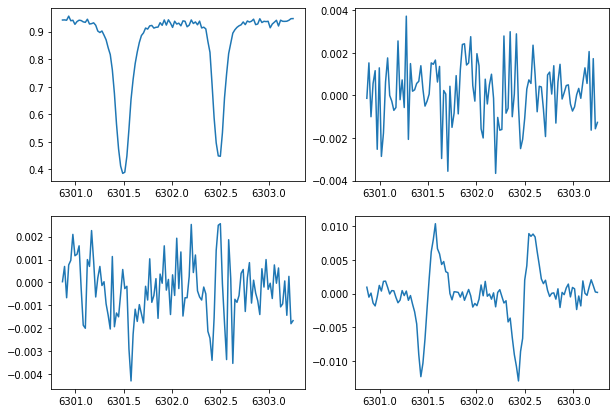

In [6]:
i=100
j=200
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,stokes[i,j,0])
plt.subplot(222)
plt.plot(ll,stokes[i,j,1])
plt.subplot(223)
plt.plot(ll,stokes[i,j,2])
plt.subplot(224)
plt.plot(ll,stokes[i,j,3])

In [7]:
#initialize the methods:
me = MilneEddington.MilneEddington(regions, lines, nthreads=1)

In [8]:
# set up noise etc
noise_level = 1.e-3
sig = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
sig += noise_level
sig[0] *= 10. #noise is larger for I, because of systematics

In [9]:
nx = 1
ny = 1
iGuessed = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
guessed_initial  = me.repeat_model(iGuessed, nx, ny)
to_fit = stokes[i,j].reshape(1,1,4,112)
    
#
# This is where the inversion happens:
#
model_out, syn_out, chi2 = me.invert(guessed_initial, to_fit, sig, nRandom = 20, nIter=100, chi2_thres=1.0, verbose=False)


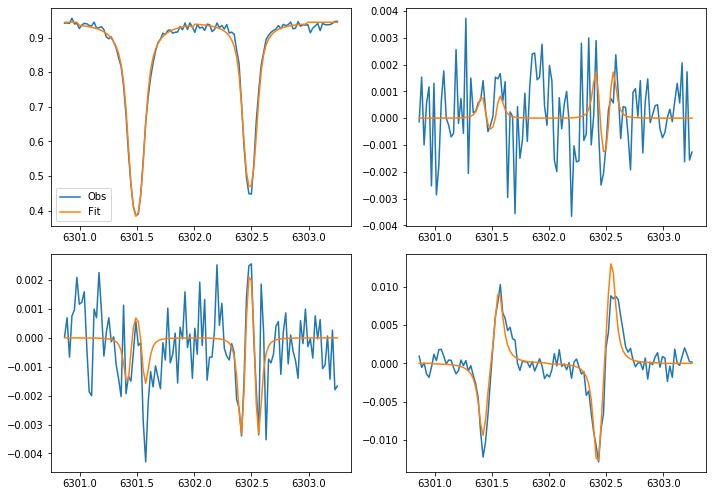

In [10]:
#test the plot
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,to_fit[0,0,0],label='Obs')
plt.plot(ll,syn_out[0,0,0],label='Fit')
plt.legend()
plt.subplot(222)
plt.plot(ll,to_fit[0,0,1],label='Obs')
plt.plot(ll,syn_out[0,0,1],label='Fit')
plt.subplot(223)
plt.plot(ll,to_fit[0,0,2],label='Obs')
plt.plot(ll,syn_out[0,0,2],label='Fit')
plt.subplot(224)
plt.plot(ll,to_fit[0,0,3],label='Obs')
plt.plot(ll,syn_out[0,0,3],label='Fit')
plt.tight_layout()

In [14]:
# Now we will try the same but for a chunk of pixels, re-alloc something:
me = MilneEddington.MilneEddington(regions, lines, nthreads=8)

pyMilne::dealloc: cleaning-up...


In [16]:
%%time
i = 0
j = 0
nx = 200
ny = 200
iGuessed = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
guessed_initial  = me.repeat_model(iGuessed, nx, ny)
to_fit = stokes[i:i+nx,j:j+ny].reshape(nx,ny,4,112)
    
#
# This is where the inversion happens:
#
model_out, syn_out, chi2 = me.invert(guessed_initial, to_fit, sig, nRandom = 10, nIter=50, chi2_thres=1.0, verbose=False)

CPU times: user 6min 48s, sys: 1.03 s, total: 6min 49s
Wall time: 6min 48s


In [12]:
print(chi2)

[[2.29162235 1.75011696 1.6040249  ... 2.00462736 2.15611895 1.83489558]
 [2.29162235 1.75104323 1.6040249  ... 2.00443008 2.15493347 1.82953432]
 [2.29162235 1.75104323 1.59598131 ... 1.99881351 2.15611895 1.8350992 ]
 ...
 [1.57074123 1.82397561 1.46042378 ... 2.05945117 2.03577522 1.98030483]
 [1.90182841 2.12052424 1.75064774 ... 1.71178424 1.63010602 1.92570763]
 [1.52621565 1.98770074 1.7061025  ... 1.75092812 1.56979874 1.81033077]]


In [94]:
model_out.shape
#model_out = model_out.reshape(nx,ny,9)

(512, 873, 9)

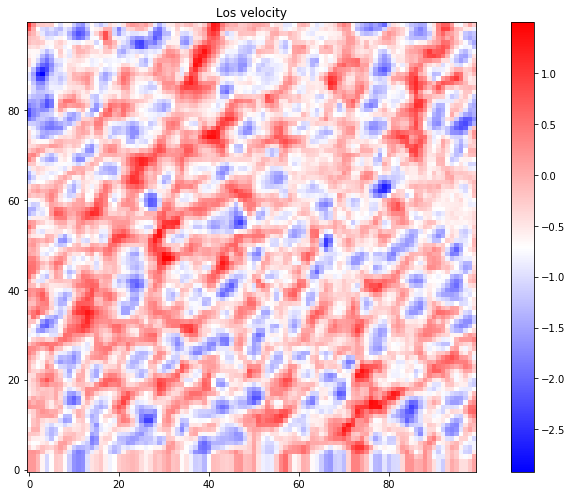

In [13]:
# Numbers look good, now let's try and plot some parameter maps:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,3],cmap='bwr',origin='lower')
plt.title("Los velocity")
plt.colorbar()
plt.tight_layout()

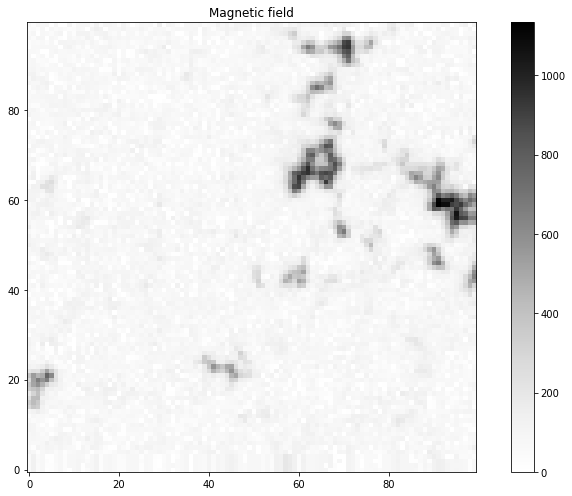

In [14]:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,0],cmap='Greys',origin='lower')
plt.title("Magnetic field")
plt.colorbar()
plt.tight_layout()

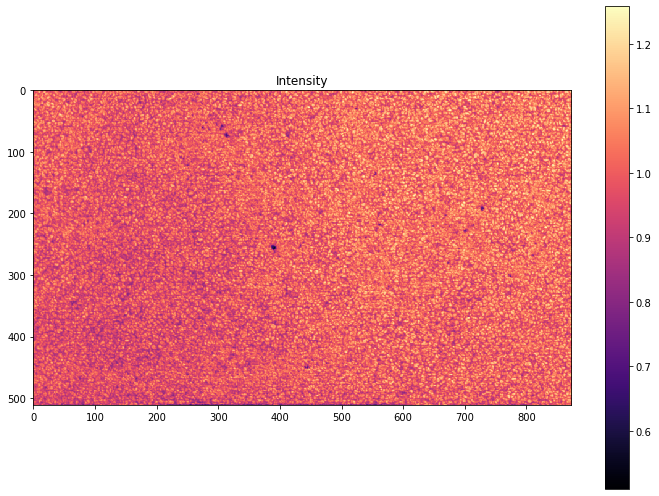

In [15]:
plt.figure(figsize=[10,7])
plt.imshow(stokes[:,:,0,0],cmap='magma')
plt.title("Intensity")
plt.colorbar()
plt.tight_layout()